# Compute the density of waves over the entire DUNEX experiment

In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import netCDF4 as nc
import numpy as np
from scipy import stats

import mission_tools

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
mission_list = glob.glob('../microSWIFT_data/final_dataset/mission_*.nc')
bathy_file = '../microSWIFT_data/FRFdata/' \
             'FRF_geomorphology_DEMs_surveyDEM_20211021.nc'

In [3]:
wave_x_locs_all = []
wave_y_locs_all = []

for mission_nc in mission_list:
    mission_dataset = nc.Dataset(mission_nc, mode='r')

    x_locations = mission_dataset['xFRF'][:]
    y_locations = mission_dataset['yFRF'][:]
    eta = mission_dataset['sea_surface_elevation'][:]
    time = mission_dataset['time'][:]

    wave_heights, \
    wave_x_locs, \
    wave_y_locs = mission_tools.compute_individual_waves(x_locations,
                                                        y_locations,
                                                        eta, time,
                                                        bathy_file)

    indices = np.logical_not(np.logical_or(np.isnan(wave_x_locs),
                                            np.isnan(wave_y_locs)))     
    indices = np.array(indices)
    wave_x_locs = np.array(wave_x_locs)[indices]
    wave_y_locs = np.array(wave_y_locs)[indices]

    wave_x_locs_all.append(wave_x_locs)
    wave_y_locs_all.append(wave_y_locs)

wave_x_locs_all = np.concatenate(wave_x_locs_all).flatten()
wave_y_locs_all = np.concatenate(wave_y_locs_all).flatten()

print(f'Total Number of Waves Measured: {wave_x_locs_all.size}')

Total Number of Waves Measured: 116307


## Plot the density of all individual waves 

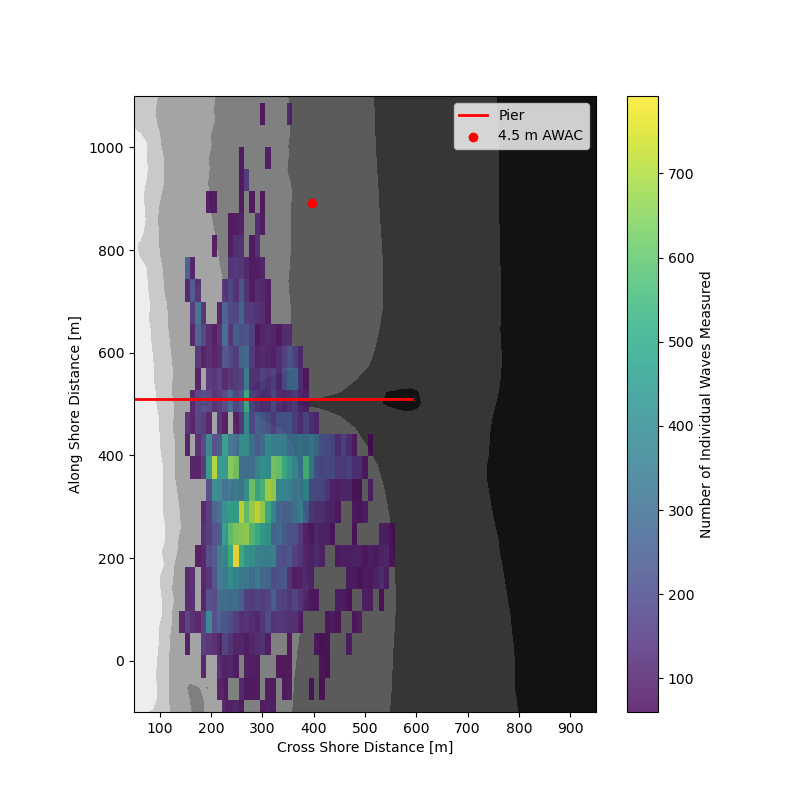

In [4]:
fig, ax = plt.subplots(figsize=(8,8))

bathy_dataset = nc.Dataset(bathy_file)
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],
                                    bathy_dataset['yFRF'][:])
bathy = bathy_dataset['elevation'][0,:,:]
ax.contourf(xFRF_grid, yFRF_grid, bathy, cmap='gray')
h, x_edge, y_edge, map = ax.hist2d(wave_x_locs_all,
                wave_y_locs_all,
                bins=50, cmap='viridis', alpha=0.8, cmin=60)
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Number of Individual Waves Measured')
ax.plot([50,591],[510,510], linewidth=2, color='r', label='Pier') # coordinates of pier
awac4p5m_location = [397.35, 890.98] # Converted from lat lon locations 
                                     # published on FRF data portal
ax.scatter(awac4p5m_location[0],awac4p5m_location[1],
           color='r', label='4.5 m AWAC')

ax.set_xlim([np.min(xFRF_grid), np.max(xFRF_grid)])
ax.set_ylim([np.min(yFRF_grid), np.max(yFRF_grid)])
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Along Shore Distance [m]')
ax.set_aspect('equal')
ax.legend()

bathy_dataset.close()

In [5]:
print(np.diff(x_edge))
print(np.diff(y_edge))

[10.49114828 10.49114828 10.49114828 10.49114828 10.49114828 10.49114828
 10.49114828 10.49114828 10.49114828 10.49114828 10.49114828 10.49114828
 10.49114828 10.49114828 10.49114828 10.49114828 10.49114828 10.49114828
 10.49114828 10.49114828 10.49114828 10.49114828 10.49114828 10.49114828
 10.49114828 10.49114828 10.49114828 10.49114828 10.49114828 10.49114828
 10.49114828 10.49114828 10.49114828 10.49114828 10.49114828 10.49114828
 10.49114828 10.49114828 10.49114828 10.49114828 10.49114828 10.49114828
 10.49114828 10.49114828 10.49114828 10.49114828 10.49114828 10.49114828
 10.49114828 10.49114828]
[43.08573284 43.08573284 43.08573284 43.08573284 43.08573284 43.08573284
 43.08573284 43.08573284 43.08573284 43.08573284 43.08573284 43.08573284
 43.08573284 43.08573284 43.08573284 43.08573284 43.08573284 43.08573284
 43.08573284 43.08573284 43.08573284 43.08573284 43.08573284 43.08573284
 43.08573284 43.08573284 43.08573284 43.08573284 43.08573284 43.08573284
 43.08573284 43.08573284 

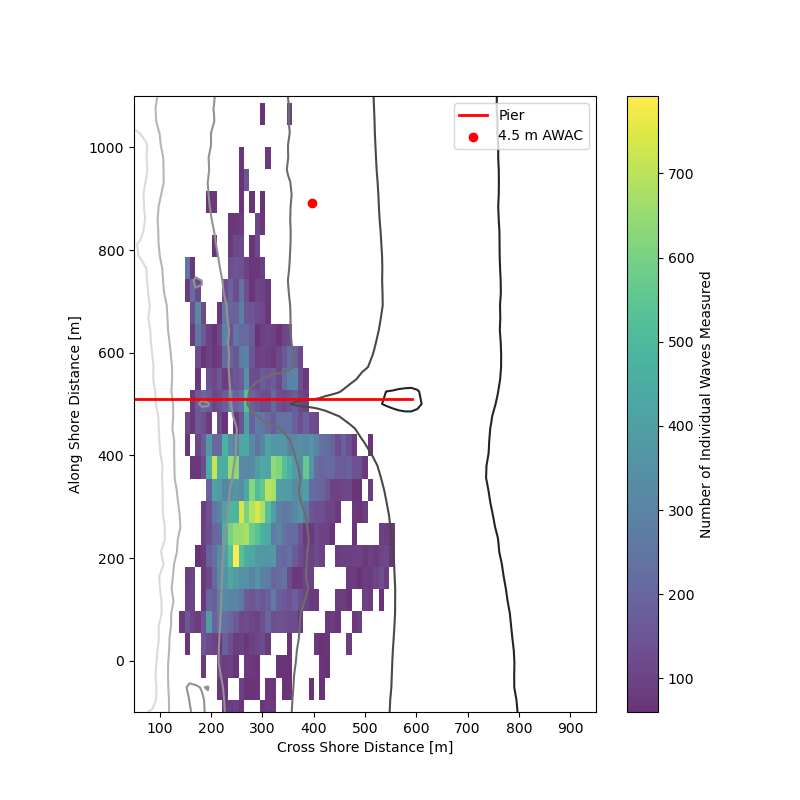

In [6]:
fig, ax = plt.subplots(figsize=(8,8))

bathy_dataset = nc.Dataset(bathy_file)
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],
                                    bathy_dataset['yFRF'][:])
bathy = bathy_dataset['elevation'][0,:,:]
ax.contour(xFRF_grid, yFRF_grid, bathy, cmap='gray')
h, x_edge, y_edge, map = ax.hist2d(wave_x_locs_all,
                wave_y_locs_all,
                bins=50, cmap='viridis', alpha=0.8, cmin=60)
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Number of Individual Waves Measured')
ax.plot([50,591],[510,510], linewidth=2, color='r', label='Pier') # coordinates of pier
awac4p5m_location = [397.35, 890.98] # Converted from lat lon locations 
                                     # published on FRF data portal
ax.scatter(awac4p5m_location[0],awac4p5m_location[1],
           color='r', label='4.5 m AWAC')

ax.set_xlim([np.min(xFRF_grid), np.max(xFRF_grid)])
ax.set_ylim([np.min(yFRF_grid), np.max(yFRF_grid)])
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Along Shore Distance [m]')
ax.set_aspect('equal')
ax.legend()

bathy_dataset.close()

In [7]:
# Plot the GPS measurement density which which show where we have Level 1 data 
x_locs_all = []
y_locs_all = []

for mission_nc in mission_list:
    mission_dataset = nc.Dataset(mission_nc, mode='r')

    x_locations = mission_dataset['xFRF'][:].compressed()
    y_locations = mission_dataset['yFRF'][:].compressed()
    nan_inds = np.isnan(x_locations)
    x_locs_all.append(x_locations[~nan_inds])
    y_locs_all.append(y_locations[~nan_inds])
    mission_dataset.close()

x_locs_all = np.concatenate(x_locs_all)
y_locs_all = np.concatenate(y_locs_all)

print(f'Total x measured points: {x_locs_all.size}')
print(f'Total y measured points: {y_locs_all.size}')


Total x measured points: 8009472
Total y measured points: 8009472


/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_48843/725558317.py:19: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(xFRF_grid, yFRF_grid, bathy, cmap='gray', label='Bathymetry Contours')


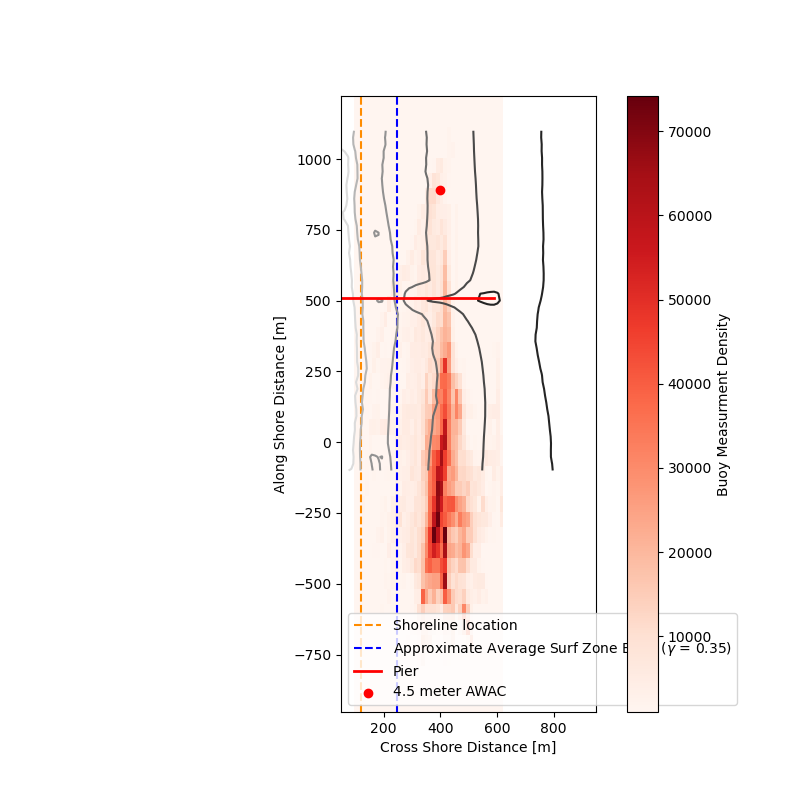

In [8]:
fig, ax = plt.subplots(figsize=(8,8))

bathy_dataset = nc.Dataset(bathy_file)
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],
                                    bathy_dataset['yFRF'][:])
bathy = bathy_dataset['elevation'][0,:,:]

# get shoreline and average surfzone location
shoreline_location = np.interp(0, np.flip(np.nanmean(bathy, axis=0)), np.flip(bathy_dataset['xFRF'][:]))
gamma = 0.35
dataset_8marray = nc.Dataset('../microSWIFT_data/FRFdata/FRF-ocean_waves_8m-array_202110.nc')
hs_avg_8marray = np.mean(dataset_8marray['waveHs'][:])
break_depth = hs_avg_8marray / gamma
xs_gamma_location = np.interp(-break_depth, np.flip(np.nanmean(bathy, axis=0)), np.flip(bathy_dataset['xFRF'][:]))
ax.axvline(shoreline_location, label='Shoreline location', color='darkorange', linestyle='dashed')
ax.axvline(xs_gamma_location, label='Approximate Average Surf Zone Edge ($\gamma$ = 0.35)', color='b', linestyle='dashed')

# Plot microSWIFT measurement locations
ax.contour(xFRF_grid, yFRF_grid, bathy, cmap='gray', label='Bathymetry Contours')
h, xedges, yedges = np.histogram2d(x_locs_all, y_locs_all, bins=(40, 40), density=False)
X, Y = np.meshgrid(xedges, yedges)
map = ax.pcolormesh(X, Y, h, vmin=1000, cmap='Reds')
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Buoy Measurment Density')
ax.plot([50,591],[510,510], linewidth=2, color='r', label='Pier') # coordinates of pier
awac4p5m_location = [397.35, 890.98] # Converted from lat lon locations 
                                     # published on FRF data portal
ax.scatter(awac4p5m_location[0],awac4p5m_location[1],
           color='r', label='4.5 meter AWAC')

ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Along Shore Distance [m]')
ax.set_aspect('equal')
ax.legend()

bathy_dataset.close()

In [9]:
print(np.diff(xedges))
print(np.diff((yedges)))

[13.20107996 13.20107996 13.20107996 13.20107996 13.20107996 13.20107996
 13.20107996 13.20107996 13.20107996 13.20107996 13.20107996 13.20107996
 13.20107996 13.20107996 13.20107996 13.20107996 13.20107996 13.20107996
 13.20107996 13.20107996 13.20107996 13.20107996 13.20107996 13.20107996
 13.20107996 13.20107996 13.20107996 13.20107996 13.20107996 13.20107996
 13.20107996 13.20107996 13.20107996 13.20107996 13.20107996 13.20107996
 13.20107996 13.20107996 13.20107996 13.20107996]
[54.39160558 54.39160558 54.39160558 54.39160558 54.39160558 54.39160558
 54.39160558 54.39160558 54.39160558 54.39160558 54.39160558 54.39160558
 54.39160558 54.39160558 54.39160558 54.39160558 54.39160558 54.39160558
 54.39160558 54.39160558 54.39160558 54.39160558 54.39160558 54.39160558
 54.39160558 54.39160558 54.39160558 54.39160558 54.39160558 54.39160558
 54.39160558 54.39160558 54.39160558 54.39160558 54.39160558 54.39160558
 54.39160558 54.39160558 54.39160558 54.39160558]


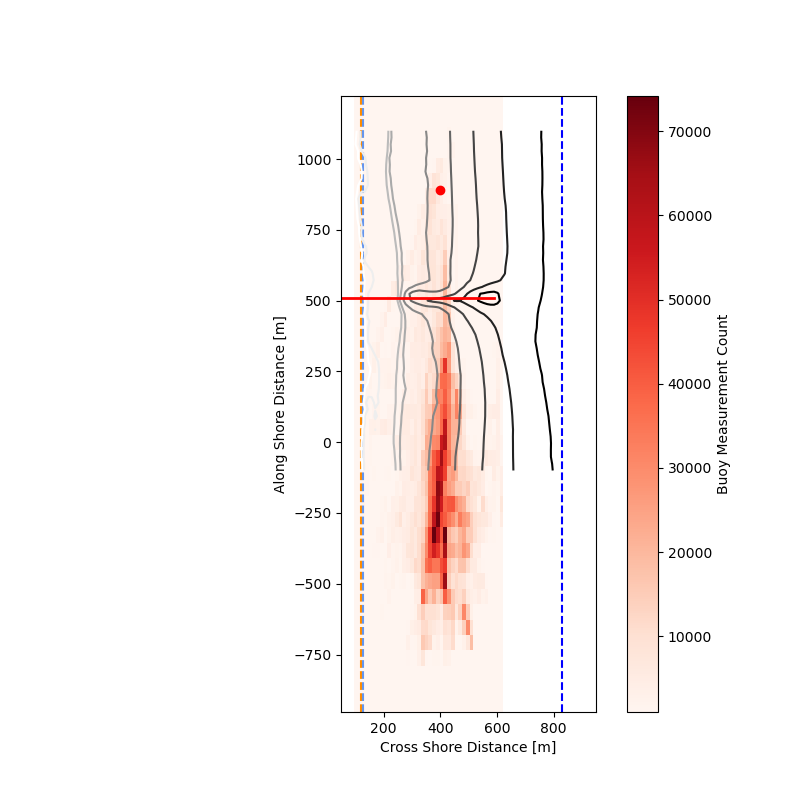

In [55]:
fig, ax = plt.subplots(figsize=(8,8))

bathy_dataset = nc.Dataset(bathy_file)
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],
                                    bathy_dataset['yFRF'][:])
bathy = bathy_dataset['elevation'][0,:,:]

# get shoreline and average surfzone location
shoreline_location = np.interp(0, np.flip(np.nanmean(bathy, axis=0)), np.flip(bathy_dataset['xFRF'][:]))
gamma = 0.35
dataset_8marray = nc.Dataset('../microSWIFT_data/FRFdata/FRF-ocean_waves_8m-array_202110.nc')
hs_min = np.min(dataset_8marray['waveHs'][:])
hs_max = np.max(dataset_8marray['waveHs'][:])
break_depth_min = hs_min / gamma
break_depth_max = hs_max / gamma
xs_gamma_location_min = np.interp(-break_depth_min, np.flip(np.nanmean(bathy, axis=0)), np.flip(bathy_dataset['xFRF'][:]))
xs_gamma_location_max = np.interp(-break_depth_max, np.flip(np.nanmean(bathy, axis=0)), np.flip(bathy_dataset['xFRF'][:]))
ax.axvline(shoreline_location, label='Shoreline location', color='darkorange', linestyle='dashed')
ax.axvline(xs_gamma_location_min, label='Minimum Surf Zone Edge', color='cornflowerblue', linestyle='dashed')
ax.axvline(xs_gamma_location_max, label='Maximum Surf Zone Edge', color='b', linestyle='dashed')

# Plot microSWIFT measurement locations
ax.contour(xFRF_grid, yFRF_grid, bathy, levels=[-8, -7, -6, -5, -4, -3, -2.5, -1, -0.5], cmap='gray')
h, xedges, yedges = np.histogram2d(x_locs_all, y_locs_all, bins=(40, 40), density=False)
X, Y = np.meshgrid(xedges, yedges)
map = ax.pcolormesh(X, Y, h, vmin=1000, cmap='Reds')
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Buoy Measurement Count')
ax.plot([50,591],[510,510], linewidth=2, color='r', label='Pier') # coordinates of pier
awac4p5m_location = [397.35, 890.98] # Converted from lat lon locations 
                                     # published on FRF data portal
ax.scatter(awac4p5m_location[0],awac4p5m_location[1],
           color='r', label='4.5 meter AWAC')

ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Along Shore Distance [m]')
ax.set_aspect('equal')
ax.legend()

bathy_dataset.close()

In [11]:
print(np.round(hs_min, decimals=3))
print(np.round(hs_max, decimals=3))

0.194
2.934


In [35]:
bathy

masked_array(
  data=[[ 2.16171197,  2.11229036,  2.02809403, ..., -8.83958408,
         -8.91663515, -8.99394551],
        [ 2.74125319,  2.68615497,  2.59230074, ..., -8.84358392,
         -8.92173811, -8.9979998 ],
        [ 2.86120586,  2.85104783,  2.8126345 , ..., -8.84949308,
         -8.92986816, -9.01156539],
        ...,
        [ 1.54535678,  1.29802978,  1.2190206 , ..., -9.01359259,
         -9.08648304, -9.15828346],
        [ 1.15434601,  0.98968644,  0.934526  , ..., -9.01934704,
         -9.09046771, -9.15997062],
        [ 1.57552967,  1.32433946,  1.14978016, ..., -9.02796918,
         -9.08953741, -9.15512314]],
  mask=False,
  fill_value=1e+20)